# Transfer Learning

- Transfer learning is a machine learning technique where a model trained on one task is re-purposed on a second related task.
- For example, we can train a model to classify cats and dogs and then re-purpose this model to classify horses.

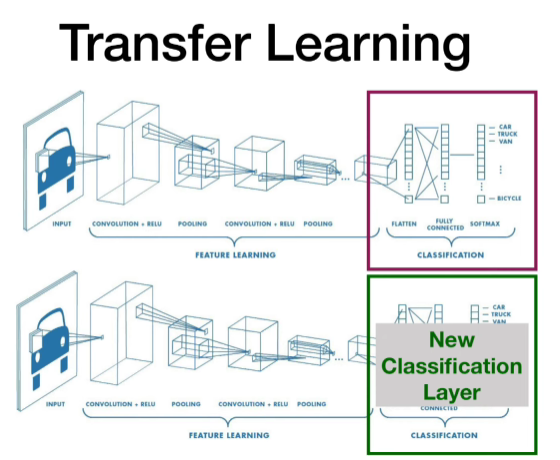

- Allow rapid generation of new model
- Training a new model from scratch can take days or weeks
- Change a last layer of a pre-trained model and re-train it on a new dataset

# ResNet18
- Use the Pre-trained ResNet18 CNN model that being trained on the millions of images from the ImageNet dataset.
- 18 layers deep
- 11.2 million parameters
- can classify images into 1000 object categories

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

# Dataset
https://www.kaggle.com/datasets/ajayrana/hymenoptera-data

In [4]:
data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)

['ants', 'bees']


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

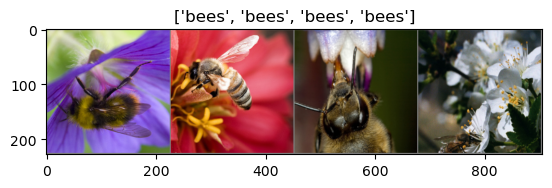

In [6]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features # in_features is the number of inputs for the last layer

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

c:\Users\fulim\anaconda3\envs\pytorch_learn\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\fulim\anaconda3\envs\pytorch_learn\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\fulim/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


In [9]:
# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...) # optimizer.step() is called here
#     validate(...)
#     scheduler.step()

# Every 7 epochs, the learning rate is multiply by a factor of 0.1.
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)


Epoch 0/24
----------
train Loss: 0.6484 Acc: 0.6189
val Loss: 0.4537 Acc: 0.8170

Epoch 1/24
----------
train Loss: 0.5550 Acc: 0.6926
val Loss: 0.3490 Acc: 0.8693

Epoch 2/24
----------
train Loss: 0.4960 Acc: 0.7664
val Loss: 0.2897 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.3982 Acc: 0.8320
val Loss: 0.2504 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.3882 Acc: 0.8361
val Loss: 0.2341 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.4270 Acc: 0.7869
val Loss: 0.1984 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.4143 Acc: 0.8074
val Loss: 0.1980 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3594 Acc: 0.8361
val Loss: 0.2402 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.3288 Acc: 0.8770
val Loss: 0.1976 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3494 Acc: 0.8607
val Loss: 0.1938 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3380 Acc: 0.8730
val Loss: 0.2217 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3943 Acc: 0.7951
val Loss: 0.1921 Acc: 0.9412

Ep

In [10]:
#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6275 Acc: 0.6434
val Loss: 0.7311 Acc: 0.6601

Epoch 1/24
----------
train Loss: 0.5117 Acc: 0.7746
val Loss: 0.1775 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.4424 Acc: 0.8115
val Loss: 0.1703 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.3671 Acc: 0.8279
val Loss: 0.2214 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.5164 Acc: 0.7623
val Loss: 0.3192 Acc: 0.8824

Epoch 5/24
----------
train Loss: 0.4597 Acc: 0.8115
val Loss: 0.1847 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.4344 Acc: 0.8238
val Loss: 0.2293 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.3550 Acc: 0.8566
val Loss: 0.1751 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.4097 Acc: 0.8402
val Loss: 0.1728 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3527 Acc: 0.8320
val Loss: 0.1729 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.4102 Acc: 0.8238
val Loss: 0.1779 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.2605 Acc: 0.8852
val Loss: 0.1909 Acc: 0.9412

Ep